# Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
'''
Input:
- csv_path: type string (path to csv file)
- time_col: datetime by default
Output:
- df: type pd.DataFrame (dataframe with discussion_date type datatime, discussion_date_ym, month, year)
'''
def load_and_prepare_story_data(csv_path, time_col='datetime'):
    df = pd.read_csv(csv_path)
    # Convert timestamps to human-readable dates
    converted_dates = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') for ts in df[time_col]]
    df['discussion_date'] = converted_dates

    df['discussion_date'] = pd.to_datetime(df['discussion_date'], format='mixed')
    df['discussion_date_ym'] = df['discussion_date'].dt.strftime("%Y-%m")

    df['month'] = df['discussion_date'].dt.month
    df['year'] = df['discussion_date'].dt.year

    # Ensure discussion_date is a categorical type
    df["discussion_date_ym"] = df["discussion_date_ym"].astype("category")
    return df

'''
Input:
- csv_path: type string (path to csv file)
- time_col: comment_datetime by default
Output:
- df: type pd.DataFrame (dataframe with discussion_date type datatime and discussion_date_ym)
'''
def load_and_prepare_comment_data(csv_path, time_col='comment_datetime'):
    df = pd.read_csv(csv_path)
    df['discussion_date'] = pd.to_datetime(df[time_col],format='mixed',utc=True)
    df['discussion_date_ym'] = df['discussion_date'].dt.strftime("%Y-%m")

    # Ensure discussion_date is a categorical type
    df["discussion_date_ym"] = df["discussion_date_ym"].astype("category")

    df["month"] = df['discussion_date'].dt.month
    df["year"] = df['discussion_date'].dt.year
    return df

'''
Input:
- start_date: type pd.datetime
- end_date: type pd.datetime
- offset_m: offset by how many month (default = 1)
Output:
- dates: type pd.Index (all months between start_date and end_date in %Y-%m format)
'''
def get_dates_between(start_date, end_date, offset_m=1):
    dates = []
    while pd.Timestamp(end_date.strftime("%Y-%m")) >= pd.Timestamp(start_date.strftime("%Y-%m")):
        dates.append(start_date.strftime("%Y-%m"))
        start_date += pd.DateOffset(months=offset_m)
    return pd.to_datetime(dates).strftime("%Y-%m")

'''
Input:
- df: output from load_and_prepare function
- senti_col: sentiment column (story_sentiment or comment_sentiment)
Output:
- df: type pd.DataFrame (all year-month date between start and end and sentiment and its counts)
'''
def get_sentiment_monthly_counts(df, senti_col="story_sentiment"):
    # Define all possible sentiments
    sentiment_values = [-1, 0, 1]

    story_date = get_dates_between(df["discussion_date"].dt.date.min(), df["discussion_date"].dt.date.max())

    # Create a complete index of discussion_date and sentiment combinations
    all_combinations = pd.MultiIndex.from_product([
        sentiment_values, story_date
    ], names=[senti_col, "discussion_date_ym"])

    # Group by discussion_date and sentiment
    result = (df.groupby([senti_col, "discussion_date_ym"])
            .size()
            .reindex(all_combinations, fill_value=0)
            .reset_index(name="count"))
    return result

'''
Input:
- df: output from load_and_prepare function
- fname: pdf filename
- senti_col: sentiment column (story_sentiment or comment_sentiment)
- y_title: String
Output:
- df: type pd.DataFrame (all year-month date between start and end and sentiment and its counts)
'''
def area_stack(original_df, fname='', senti_col='story_sentiment', y_title='Stories'):
    df = get_sentiment_monthly_counts(original_df, senti_col)

    fig, ax = plt.subplots(figsize=(12, 6))

    neg = df[df[senti_col] == -1]
    neu = df[df[senti_col] == 0]
    pos = df[df[senti_col] == 1]   

    all_dates_ym = neu['discussion_date_ym']
    plt.stackplot(all_dates_ym, neg["count"], pos["count"], neu["count"], labels=["negative", "positive", "neutral"], colors=["tomato", "lightgreen", "cornflowerblue"])

    # Ref: https://stackoverflow.com/a/69291514
    labels_of_interest = get_dates_between(min(original_df['discussion_date']), max(original_df['discussion_date']), offset_m=2)
    new_labels = [label if label in labels_of_interest else "" for label in all_dates_ym]
    ax.set_xticklabels(new_labels)

    plt.xticks(rotation=45, ha='center', fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_ylabel(f'Number of {y_title}', fontsize=15)
    ax.legend(fontsize=15)
    plt.xlim([min(all_dates_ym), max(all_dates_ym)])
    count_sum_df = df[['discussion_date_ym', 'count']].groupby(['discussion_date_ym']).sum()
    plt.ylim([0, count_sum_df['count'].max() + count_sum_df['count'].max() * 0.03])
    plt.grid()
    if fname != '':
        plt.rcParams["pdf.fonttype"] = 42  # Ensures TrueType font embedding
        plt.savefig(fname, format='pdf', bbox_inches="tight")
    plt.show()    


'''
Input:
- comment_df: output from load_and_prepare_comment_data function
- fname: provide filenames in pdf
- senti_col: sentiment_col
- v_min: min color value range
- v_max: max color value range
Output:
- df: heatmap plot output and files in pdf (if fname is provided)
'''
def strength_heat_map(comment_df, fname='', v_min=1, v_max=2):
        
    strength_map = {-1: 2, 1: 2, 0: 1} # comment_sentiment: strength
    comment_df['strength'] = [strength_map[comment_sentiment] for comment_sentiment in comment_df['comment_sentiment']]

    dates_sentiment = comment_df[['discussion_date_ym', 'strength']]
    dates_sentiment = dates_sentiment.groupby(["discussion_date_ym"]).mean(numeric_only=True).rename(columns={'strength': 'strength_mean'}).dropna()

    dates = comment_df[['discussion_date_ym', 'month', 'year']].drop_duplicates(subset=['discussion_date_ym']).set_index('discussion_date_ym')

    join_df = dates_sentiment.join(dates, on='discussion_date_ym', how='left')
    pivot_df = join_df.pivot(index='year', columns='month', values='strength_mean')
    plt.figure(figsize=(9,2))
    ax = sns.heatmap(pivot_df, cmap=sns.color_palette("PuBuGn", as_cmap=True), annot=True, fmt=".2f", vmin=v_min, vmax=v_max)
    ax.set(xlabel="Month", ylabel="Year")
    if fname != '':
        plt.rcParams["pdf.fonttype"] = 42  # Ensures TrueType font embedding
        plt.savefig(fname, format='pdf', bbox_inches="tight") 

# Sentiment Trend: Area Stack

### GH AI Story

In [4]:
hn_gh_ai_story_df = load_and_prepare_story_data('..\\dataset\\hn_gh_ai_story_sentiment.csv')

C:\Users\warit\AppData\Local\Temp\ipykernel_11772\2947676580.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  converted_dates = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') for ts in df[time_col]]


C:\Users\warit\AppData\Local\Temp\ipykernel_23608\2947676580.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = (df.groupby([senti_col, "discussion_date_ym"])
C:\Users\warit\AppData\Local\Temp\ipykernel_23608\2947676580.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


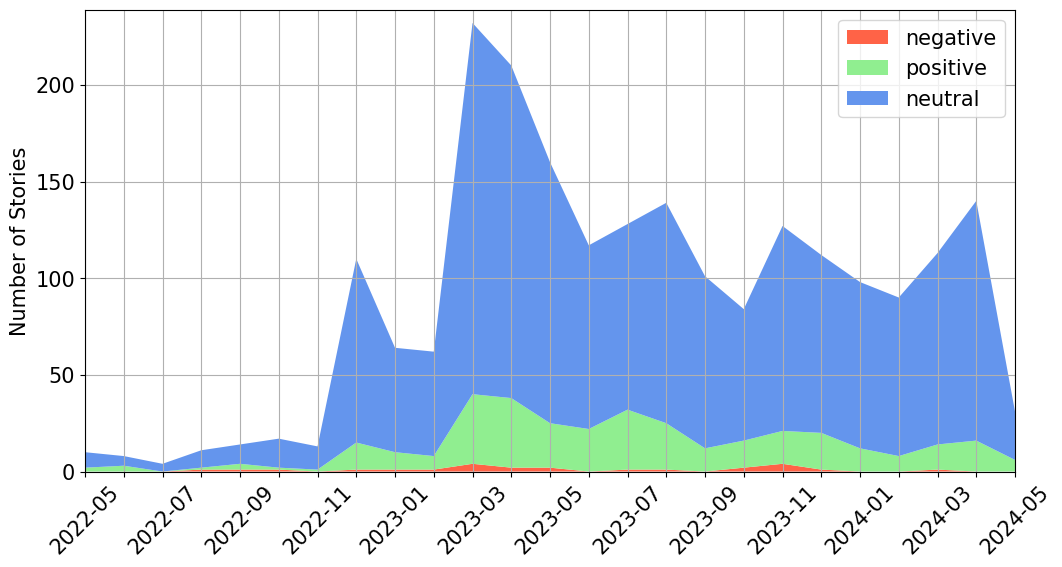

In [4]:
area_stack(hn_gh_ai_story_df, fname='plots\\hn_gh_ai_story_area_stack.pdf', senti_col='story_sentiment', y_title='Stories')

### GH AI Comment

In [3]:
hn_gh_ai_comment_df = load_and_prepare_comment_data('..\\dataset\\hn_gh_ai_comment_sentiment.csv')

C:\Users\warit\AppData\Local\Temp\ipykernel_23608\2947676580.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = (df.groupby([senti_col, "discussion_date_ym"])
C:\Users\warit\AppData\Local\Temp\ipykernel_23608\2947676580.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


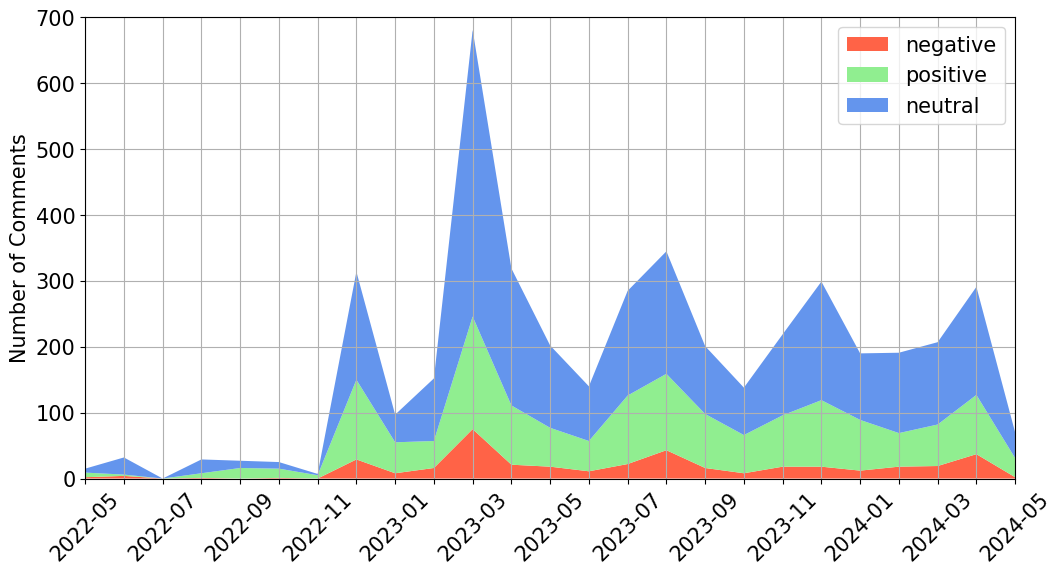

In [6]:
area_stack(hn_gh_ai_comment_df, fname='plots\\hn_gh_ai_comment_area_stack.pdf', senti_col='comment_sentiment', y_title='Comments')

# Reaction Analysis: Heat Map

C:\Users\warit\AppData\Local\Temp\ipykernel_7256\3467928716.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dates_sentiment = dates_sentiment.groupby(["discussion_date_ym"]).mean(numeric_only=True).rename(columns={'strength': 'strength_mean'}).dropna()


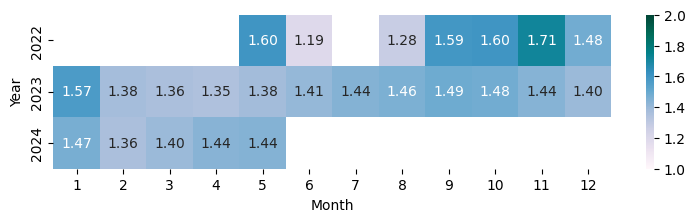

In [7]:
strength_heat_map(hn_gh_ai_comment_df, fname='plots\\hn_gh_ai_comment_strength_heatmap.pdf', v_min=1, v_max=2)